# Analyse du dataset 1

Après l'analyse réalisée dans le notebook 02, nous avons remarqué que toutes les images du dataset 1 sont des factures en niveaux de gris et de même taille.  
Le but de ce notebook est donc de récupérer les fréquences des mots qui caractérisent cette catégorie d'images.

In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\Bryan Fernandez\Desktop\DataScientest\doc-classifier


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

C:\Users\Bryan Fernandez\AppData\Local\Temp\ipykernel_4804\2136054206.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Nous n'avons pas besoin de réaliser d'océrisation pour ce dataset car elle a déjà été réalisée. Les résultats se trouvent dans le dossier ocr dans des fichiers .xml avec la structure suivante :  
  
$\;$\<TextRegion>  
$\;\;\;\;\;\;$\<TextLine>  
$\;\;\;\;\;\;\;\;\;\;$\<Word>  
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$\<Unicode> TEXT \</Unicode>  
$\;\;\;\;\;\;\;\;\;\;$\</Word>  
$\;\;\;\;\;\;$\</TextLine>  
$\;$\</TextRegion>  
  
Le text se trouve dans l'attribut \<Unicode>

In [3]:
# Path to the dataset
file_path = "data/raw/data_01/ocr"

# Retrieving the list of files's names in the folder
list_filename = os.listdir(file_path)

Nous avons maintenant concaténé tous les textes en un seul et même string.

In [4]:
from src import img_xml_unicode

unicode = img_xml_unicode(list_filename, file_path)

Après avoir étudié un exemple de XML, nous avons remarqué la présence de l'attribut **"language"**. Nous avons extrait la langue du texte pour chaque image.

In [5]:
from src import img_xml_language

img_xml_language(list_filename, file_path)

['en-US']


Nous n'avons que la valeur **"en_US"** nous présumons qu'il s-agit de la langue anglaise. Pour la suite, nous avons dans un premier temps tokenizé  en mot notre string

En utilisant la classe RegexpTokenizer du module nltk.tokenize, on instancie une expression régulière qui sera utilisée pour définir comment le texte devrait être divisé en tokens lors de l'analyse.  
  
L'expréssion regex fournie (**[A-Za-z]{3,}**) signifie :  
  
[A-Za-z\\.]: Correspond à n'importe quel caractère alphabétique majuscule ou minuscule.
{3,}: Indique que la séquence précédente doit apparaître au moins 3 fois de manière consécutive.  

Ainsi, le tokenizer va diviser le texte en tokens en considérant les séquences d'au moins 3 caractères alphabétiques comme des tokens individuels.

In [6]:
from nltk.tokenize.regexp import RegexpTokenizer

# Initialize a tokenizer 
tokenizer = RegexpTokenizer("[a-zA-Z]{3,}")

# Tokenize the text
tokens = tokenizer.tokenize(unicode.lower())



Nous avons ensuite retiré les "mots vides" (*stop words*) de notre variable **tokens**.

In [7]:
from src import stop_words_filtering

tokens = stop_words_filtering(tokens, 'english')

Nous avons fait une lemmatisation afin de normaliser le texte et réduire le vocabulaire à sa forme la plus fondamentale (forme dans le dictionnaire) dans la langue souhaitée.

In [8]:
from src import lemmatize_english

lemmatized_tokens = lemmatize_english(tokens)

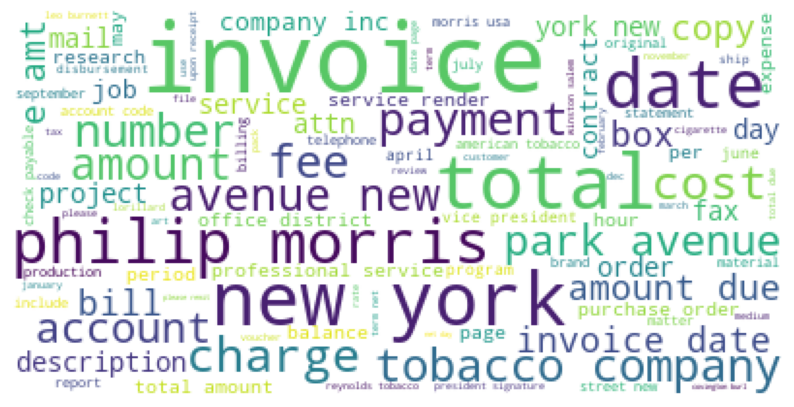

In [9]:
from src import create_wordcloud

create_wordcloud(lemmatized_tokens)

Ce WordCloud nous permet de voir en un coup d'oeil les mots fréquents dans notre texte.  

In [10]:
from collections import Counter

# Use Counter to get word frequencies
word_freq = Counter(lemmatized_tokens)

# Get the top 20 words
top_20_words = word_freq.most_common(20)


Nous avons ensuite affiché la fréquence des mots dans un diagramme en bar.

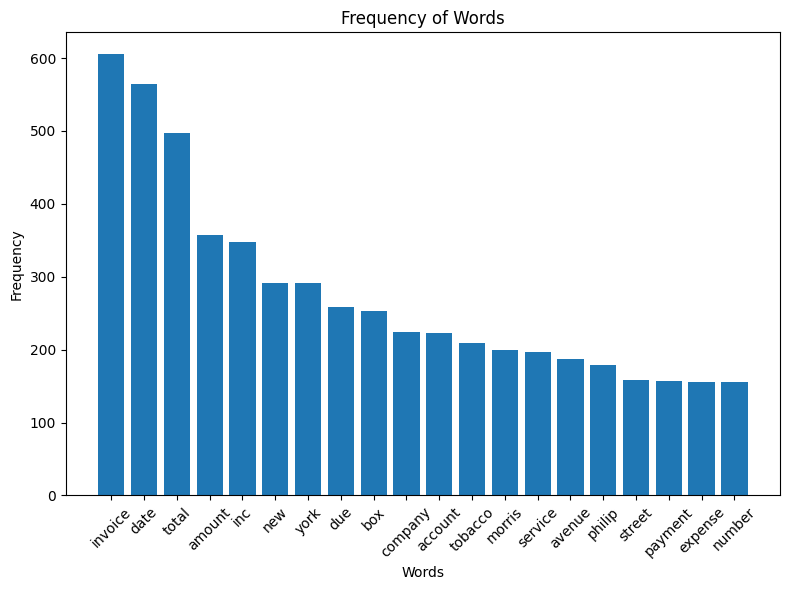

In [11]:
words, frequencies = zip(*top_20_words)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
